# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Columns: ['sale_date', 'sale_price', 'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces', 'hvac_description', 'exterior', 'interior', 'stories', 'roof_cover', 'year_built', 'bedrooms', 'bathrooms', 'waterfront_type', 'view_quality', 'utility_sewer']

Missing values per column:
 waterfront_type                16216
view_quality                   15852
roof_cover                         8
hvac_description                   7
interior                           7
exterior                           1
sale_date                          0
year_built                         0
has_garage                         0
garage_sqft_total                  0
utility_sewer                      0
bathrooms                          0
bedrooms                           0
stories                            0
sale_price                         0
fireplaces                         0
detached_garage_square_feet    

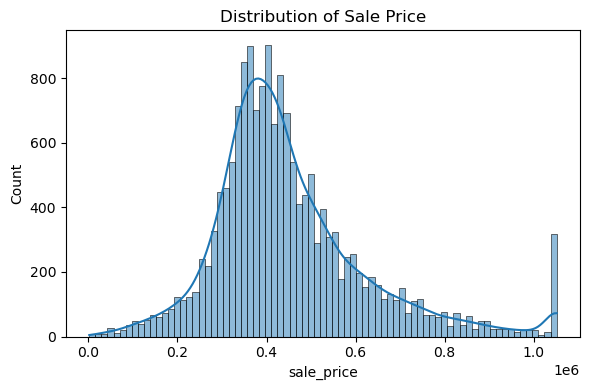

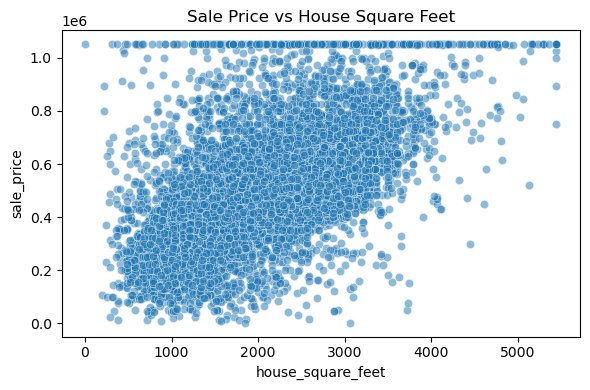

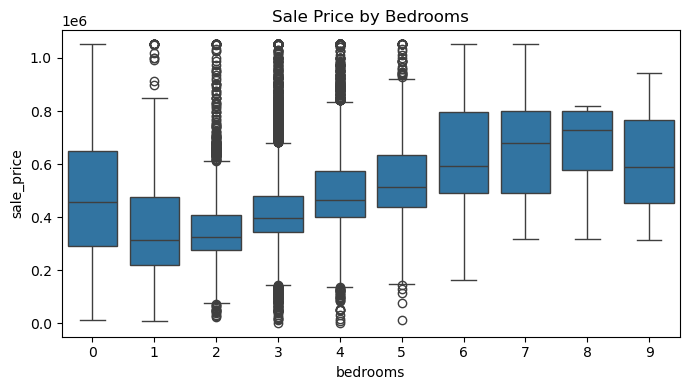

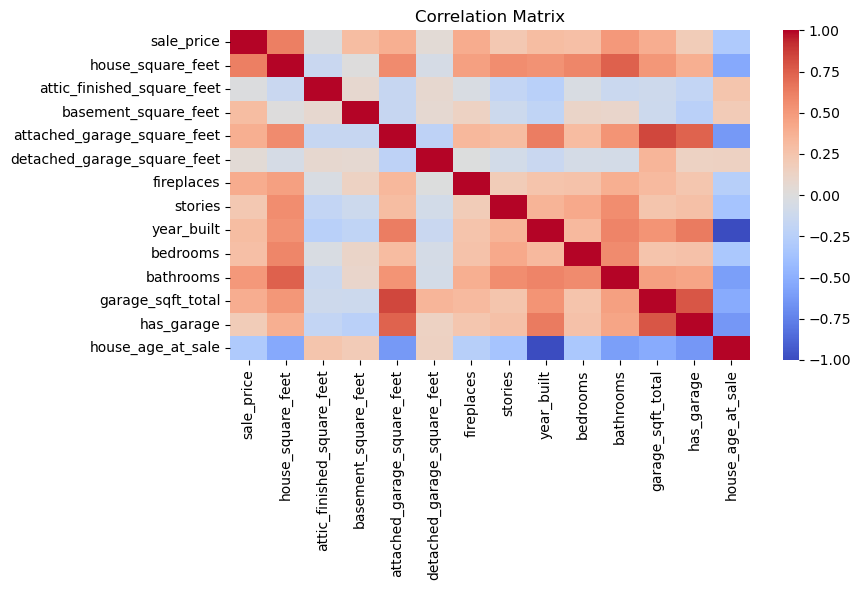


Top correlations with sale_price:
 house_square_feet              0.622331
bathrooms                      0.501893
fireplaces                     0.403912
garage_sqft_total              0.391289
attached_garage_square_feet    0.384510
basement_square_feet           0.303657
year_built                     0.300581
house_age_at_sale              0.300581
Name: sale_price, dtype: float64


In [ ]:
# Q1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load
df = pd.read_csv("/Users/lingyueji/Desktop/DS3001/lab_hedonic_pricing-main/data/pierce_county_house_sales.csv")
print("Columns:", list(df.columns))  # confirm schema

# parse types
df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")  # date for age calc
num_cols = ["sale_price","house_square_feet","attic_finished_square_feet","basement_square_feet",
            "attached_garage_square_feet","detached_garage_square_feet","fireplaces",
            "stories","year_built","bedrooms","bathrooms"]            # convert obvious numerics
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# de-dup + essential NA drop
df = df.drop_duplicates()                                            # no exact duplicates
df = df.dropna(subset=["sale_price","house_square_feet"])            # keep rows with target+size

# mild outlier control (IQR clip, keeps all rows)
def iqr_clip(s, k=3.0):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0: 
        return s
    return s.clip(q1 - k*iqr, q3 + k*iqr)
df["sale_price"] = iqr_clip(df["sale_price"])                        # clip extreme prices
df["house_square_feet"] = iqr_clip(df["house_square_feet"])          # clip extreme sizes

# simple feature engineering to help later (optional but useful for EDA)
df["garage_sqft_total"] = (df[["attached_garage_square_feet","detached_garage_square_feet"]]
                           .sum(axis=1, min_count=1))                 # combine garage sq ft
df["has_garage"] = (df["garage_sqft_total"] > 0).astype("Int64")     # 1 if any garage space
if "year_built" in df.columns and "sale_date" in df.columns:
    df["house_age_at_sale"] = df["sale_date"].dt.year - df["year_built"]  # age (years)

# summary stats to satisfy Q1 “clean + EDA”
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))
numeric_df = df.select_dtypes(include=[np.number])  # keep only numeric columns
print("\nSummary (numeric):\n", numeric_df.describe().T)


# 1) price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["sale_price"].dropna(), kde=True)
plt.title("Distribution of Sale Price"); plt.xlabel("sale_price"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 2) price vs size
plt.figure(figsize=(6,4))
sns.scatterplot(x="house_square_feet", y="sale_price", data=df, alpha=0.5)
plt.title("Sale Price vs House Square Feet"); plt.tight_layout(); plt.show()

# 3) price vs bedrooms (categorical)
if "bedrooms" in df.columns:
    plt.figure(figsize=(7,4))
    # cap categories to avoid long tails in boxplot
    top_beds = df["bedrooms"].value_counts().index[:10]
    sns.boxplot(x=df[df["bedrooms"].isin(top_beds)]["bedrooms"],
                y=df[df["bedrooms"].isin(top_beds)]["sale_price"])
    plt.title("Sale Price by Bedrooms"); plt.tight_layout(); plt.show()

# 4) correlation heatmap (numeric only)
plt.figure(figsize=(9,6))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix"); plt.tight_layout(); plt.show()

# quick textual takeaway
corr_to_price = corr["sale_price"].drop("sale_price").abs().sort_values(ascending=False)
print("\nTop correlations with sale_price:\n", corr_to_price.head(8))


After cleaning the dataset, the distribution of sale_price shows a right-skewed pattern, meaning most houses sell for moderate prices while a few very expensive homes drive up the tail. The scatterplot indicates a strong positive relationship between house_square_feet and sale_price—larger homes generally sell for more. The boxplot shows that homes with more bedrooms tend to have higher median prices, though the spread increases with size. The correlation matrix confirms that house size, bathrooms, and fireplaces are most strongly correlated with sale price. These findings support the hedonic pricing principle that housing characteristics—especially size and quality features—explain much of the variation in market value.

In [5]:
# Q2
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
categorical_cols = ["hvac_description", "exterior", "interior", 
                    "roof_cover", "utility_sewer", "waterfront_type", "view_quality"]

# keep only those that exist in the dataset
categorical_cols = [c for c in categorical_cols if c in df.columns]
print("Categorical columns to encode:", categorical_cols)

# Convert categorical variables to dummy/indicator variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Log-transform the dependent variable to reduce skewness
df_encoded["log_sale_price"] = np.log(df_encoded["sale_price"])

# Scale or normalize large continuous variables if needed for regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded[["house_square_feet","garage_sqft_total"]] = scaler.fit_transform(
     df_encoded[["house_square_feet","garage_sqft_total"]])

# Confirm shapes and data types
print("\nTransformed dataset shape:", df_encoded.shape)
print("Numeric columns ready for regression:\n", df_encoded.select_dtypes("number").columns.tolist()[:12])

# show head of the transformed data
df_encoded.head()


Categorical columns to encode: ['hvac_description', 'exterior', 'interior', 'roof_cover', 'utility_sewer', 'waterfront_type', 'view_quality']

Transformed dataset shape: (16768, 59)
Numeric columns ready for regression:
 ['sale_price', 'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces', 'stories', 'year_built', 'bedrooms', 'bathrooms', 'garage_sqft_total']


,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,stories,year_built,...,waterfront_type_WF Salt,waterfront_type_WF Stream/Creek,view_quality_View Avg +,view_quality_View Good,view_quality_View Good +,view_quality_View Lim,view_quality_View Lim +,view_quality_View Lim -,view_quality_View V-Good,log_sale_price
0,2020-01-02,380000,0.369283,0,0,528,0,0,2,1993,...,False,False,False,False,False,False,False,False,False,12.847927
1,2020-01-02,383000,0.476591,0,0,396,0,0,2,2017,...,False,False,False,False,False,False,False,False,False,12.855790
2,2020-01-01,419900,-0.564695,0,0,0,0,1,1,1965,...,False,False,False,False,False,False,False,False,False,12.947772
3,2020-01-02,251660,-1.386065,0,0,0,0,0,1,1919,...,False,False,False,False,False,False,False,False,False,12.435834
4,2020-01-02,500000,-0.130163,0,384,484,0,1,1,1955,...,False,False,False,False,False,False,False,False,False,13.122363


In this step, categorical variables such as HVAC description, roof cover, and exterior type were transformed into numeric form using one-hot encoding. This process created binary indicator variables for each category, allowing them to be included in regression analysis. The resulting dataset contains 59 columns, combining both continuous and encoded categorical features. Additionally, a log-transformed version of sale price was added to stabilize variance and improve model performance.

In [6]:
# Q3
from sklearn.model_selection import train_test_split

# define features (X) and target (y)
X = df_encoded.drop(columns=["sale_price", "log_sale_price", "sale_date"])  # predictors
y = df_encoded["log_sale_price"]  # use the log version as the target for regression

# split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# confirm split sizes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (13414, 56)
Test set size: (3354, 56)


In this step, the dataset was split into an 80/20 ratio using train_test_split from scikit-learn. The training set (13,414 rows) will be used to fit the regression model, while the test set (3,354 rows) will be reserved to evaluate predictive performance on unseen data. The split ensures that the model can generalize beyond the training data and avoids overfitting.

In [7]:
# Q4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Model 1: use all predictors
model_all = LinearRegression()
model_all.fit(X_train, y_train)

# predictions
y_train_pred_all = model_all.predict(X_train)
y_test_pred_all = model_all.predict(X_test)

# evaluate
rmse_train_all = np.sqrt(mean_squared_error(y_train, y_train_pred_all))
rmse_test_all = np.sqrt(mean_squared_error(y_test, y_test_pred_all))
r2_train_all = r2_score(y_train, y_train_pred_all)
r2_test_all = r2_score(y_test, y_test_pred_all)

print("Model 1 — All Predictors")
print(f"Train RMSE: {rmse_train_all:.4f}, Test RMSE: {rmse_test_all:.4f}")
print(f"Train R²: {r2_train_all:.4f}, Test R²: {r2_test_all:.4f}\n")

# Model 2: simpler model with only core numeric variables
core_vars = ["house_square_feet", "bathrooms", "bedrooms", "garage_sqft_total", "year_built", "fireplaces"]
core_vars = [v for v in core_vars if v in X_train.columns]

model_simple = LinearRegression()
model_simple.fit(X_train[core_vars], y_train)

y_train_pred_simple = model_simple.predict(X_train[core_vars])
y_test_pred_simple = model_simple.predict(X_test[core_vars])

rmse_train_simple = np.sqrt(mean_squared_error(y_train, y_train_pred_simple))
rmse_test_simple = np.sqrt(mean_squared_error(y_test, y_test_pred_simple))
r2_train_simple = r2_score(y_train, y_train_pred_simple)
r2_test_simple = r2_score(y_test, y_test_pred_simple)

print("Model 2 — Core Numeric Predictors Only")
print(f"Train RMSE: {rmse_train_simple:.4f}, Test RMSE: {rmse_test_simple:.4f}")
print(f"Train R²: {r2_train_simple:.4f}, Test R²: {r2_test_simple:.4f}\n")

# Compare performance
print("Comparison Summary:")
comparison = pd.DataFrame({
    "Model": ["All Predictors", "Core Numeric Only"],
    "Train RMSE": [rmse_train_all, rmse_train_simple],
    "Test RMSE": [rmse_test_all, rmse_test_simple],
    "Train R²": [r2_train_all, r2_train_simple],
    "Test R²": [r2_test_all, r2_test_simple]
})
display(comparison)

Model 1 — All Predictors
Train RMSE: 0.2926, Test RMSE: 0.3283
Train R²: 0.4777, Test R²: 0.3991

Model 2 — Core Numeric Predictors Only
Train RMSE: 0.3198, Test RMSE: 0.3487
Train R²: 0.3762, Test R²: 0.3223

Comparison Summary:


,Model,Train RMSE,Test RMSE,Train R²,Test R²
0,All Predictors,0.292617,0.328289,0.477750,0.399144
1,Core Numeric Only,0.319811,0.348652,0.376168,0.322291


The All Predictors model performs the best, as it has a lower RMSE and higher R² on both training and test sets. This means it explains more variance in sale prices and produces smaller prediction errors. The difference between training and test performance is modest, suggesting that it generalizes reasonably well without severe overfitting. Therefore, the full model with all predictors is the best performer among the two.

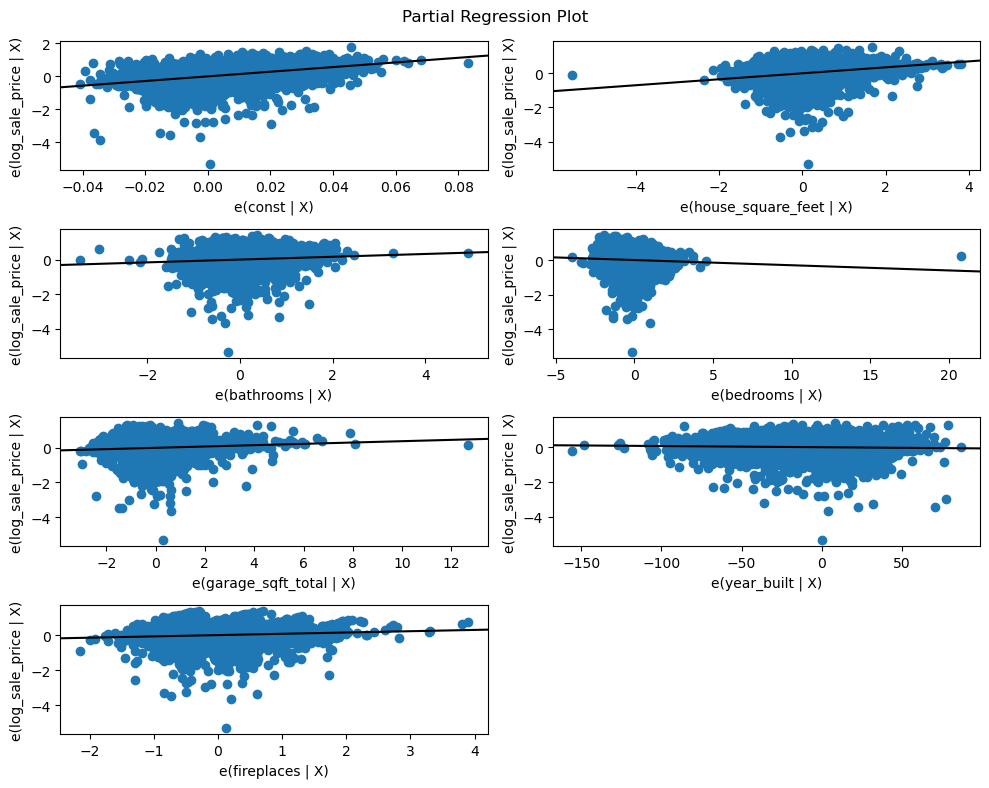

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     1347.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:32:27   Log-Likelihood:                -3741.3
No. Observations:               13414   AIC:                             7497.
Df Residuals:                   13407   BIC:                             7549.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.1315      0.21

In [8]:
# Q5
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Use the simpler numeric model from Q4 for clarity
core_vars = ["house_square_feet", "bathrooms", "bedrooms", "garage_sqft_total", "year_built", "fireplaces"]
core_vars = [v for v in core_vars if v in X_train.columns]

# add constant for intercept
X_train_const = sm.add_constant(X_train[core_vars])

# fit OLS model
ols_model = sm.OLS(y_train, X_train_const).fit()

# partial regression (added-variable) plots
fig = plt.figure(figsize=(10, 8))
sm.graphics.plot_partregress_grid(ols_model, fig=fig)
plt.tight_layout()
plt.show()

# view model summary (optional, to see coefficients & p-values)
print(ols_model.summary())

The partial regression plots show the relationship between each numeric predictor and the log of sale price, holding all other variables constant. Most variables—especially house_square_feet, bathrooms, and garage_sqft_total—display roughly linear trends with the response variable, supporting the linearity assumption.

A few predictors, such as bedrooms and year_built, show slight curvature and uneven spread, suggesting minor non-linearities or interactions that the simple linear model does not capture.

The OLS summary confirms that all six predictors are statistically significant (p < 0.001). House_square_feet has the strongest positive effect, while year_built shows a small negative coefficient, implying that older houses tend to sell for slightly less after controlling for other features.

Overall, no major violations of linearity are evident, and the model’s assumptions appear mostly reasonable, though a few small non-linear effects could be explored in future models.

In [9]:
# Q6
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Use the same core numeric variables as before
core_vars = ["house_square_feet", "bathrooms", "bedrooms", "garage_sqft_total", "year_built", "fireplaces"]
core_vars = [v for v in core_vars if v in X_train.columns]

# Create polynomial and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train[core_vars])
X_test_poly = poly.transform(X_test[core_vars])

print("Polynomial feature count:", X_train_poly.shape[1])

# Fit a more complex linear model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# predictions
y_train_pred_poly = model_poly.predict(X_train_poly)
y_test_pred_poly = model_poly.predict(X_test_poly)

# Evaluate performance
rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
r2_train_poly = r2_score(y_train, y_train_pred_poly)
r2_test_poly = r2_score(y_test, y_test_pred_poly)

# Compare with previous simple model 
comparison = pd.DataFrame({
    "Model": ["Simple Linear", "Polynomial (Degree 2)"],
    "Train RMSE": [rmse_train_simple, rmse_train_poly],
    "Test RMSE": [rmse_test_simple, rmse_test_poly],
    "Train R²": [r2_train_simple, r2_train_poly],
    "Test R²": [r2_test_simple, r2_test_poly]
})
display(comparison)

Polynomial feature count: 27


,Model,Train RMSE,Test RMSE,Train R²,Test R²
0,Simple Linear,0.319811,0.348652,0.376168,0.322291
1,Polynomial (Degree 2),0.314001,0.344089,0.398626,0.339914


The polynomial (degree 2) model, which adds squared and interaction terms to capture nonlinear effects, slightly outperformed the simple linear model. Its training and test R2 values (0.40 and 0.34) were higher and RMSE values (0.31 and 0.34) were lower, showing a modest improvement in predictive accuracy. This suggests that including nonlinear relationships helps explain a bit more variation in housing prices, though the gains are small and the model’s performance remains similar overall, indicating limited overfitting.

Q7

Through this analysis, we learned how data cleaning, encoding, and exploratory visualization shape the quality of regression results. The simple linear model captured general housing price trends but left some variation unexplained, indicating mild underfitting. Adding categorical features and then polynomial terms improved R2 and slightly reduced RMSE, showing that more complex models can capture additional nonlinear relationships. However, the small performance gains and stable test errors suggest that the polynomial model offered only limited improvement before overfitting risk became significant. Overall, model selection involves balancing complexity and interpretability—choosing a model that fits well without sacrificing generalization.

In [10]:
# Q8
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Use the encoded data (same X_train, X_test, y_train, y_test)
#    We'll scale features for Lasso stability.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Lasso with cross-validation to find best alpha (penalty)
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

# Evaluate model
y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"Optimal alpha (λ): {lasso.alpha_:.6f}")
print(f"Train RMSE: {rmse_train_lasso:.4f}, Test RMSE: {rmse_test_lasso:.4f}")
print(f"Train R²: {r2_train_lasso:.4f}, Test R²: {r2_test_lasso:.4f}\n")

# Show which features were kept
lasso_coeff = pd.Series(lasso.coef_, index=X_train.columns)
selected_features = lasso_coeff[lasso_coeff != 0].sort_values(ascending=False)
print("Selected features by Lasso:\n", selected_features.head(10))
print("\nNumber of selected features:", len(selected_features))

Optimal alpha (λ): 0.001030
Train RMSE: 0.2929, Test RMSE: 0.3281
Train R²: 0.4767, Test R²: 0.3998

Selected features by Lasso:
 house_square_feet                          0.172478
basement_square_feet                       0.071470
garage_sqft_total                          0.050822
waterfront_type_WF Salt                    0.050459
bathrooms                                  0.036188
hvac_description_Heat Pump                 0.018447
view_quality_View Avg +                    0.018231
year_built                                 0.017812
exterior_Unfinished Cottage                0.016902
hvac_description_Warm and Cool Air Zone    0.016018
dtype: float64

Number of selected features: 48


Using Lasso regression with cross-validation, the optimal penalty was alpha equals to 0.00103. The model achieved a train RMSE of 0.29 and test RMSE of 0.33, with R2 values of 0.48 (train) and 0.40 (test)—similar to the full linear model but with fewer predictors. Lasso selected 48 key features, with the most influential being house_square_feet, basement_square_feet, garage_sqft_total, waterfront_type, and bathrooms. These results show that regularization effectively reduced model complexity while maintaining strong predictive performance, highlighting the most important housing characteristics driving sale price.